# Feature Engineering: Encoding, Scaling, and Feature Creation

This notebook demonstrates comprehensive feature engineering techniques and their impact on model performance.


In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
# Load data
with open('../adult_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (26048, 14)
Test set: (6513, 14)


## Feature Engineering Pipeline

We'll apply:
1. **One-Hot Encoding**: Better than label encoding for categorical variables
2. **Feature Scaling**: Standardize numerical features
3. **Feature Creation**: Create interaction features
4. **Feature Selection**: Select most important features


In [3]:
# Identify column types
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nAfter preprocessing:")
print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")


Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

After preprocessing:
Training shape: (26048, 100)
Test shape: (6513, 100)


## Feature Creation: Interaction Features

Let's create some interaction features that might be informative.


In [4]:
# Create interaction features from original data
# Age * Hours per week (work intensity)
X_train['age_hours'] = X_train['age'] * X_train['hours-per-week']
X_test['age_hours'] = X_test['age'] * X_test['hours-per-week']

# Capital gain - capital loss (net capital)
X_train['net_capital'] = X_train['capital-gain'] - X_train['capital-loss']
X_test['net_capital'] = X_test['capital-gain'] - X_test['capital-loss']

# Education * Hours (education-work interaction)
X_train['edu_hours'] = X_train['education-num'] * X_train['hours-per-week']
X_test['edu_hours'] = X_test['education-num'] * X_test['hours-per-week']

# Add new numerical columns to the list
new_numerical_cols = numerical_cols + ['age_hours', 'net_capital', 'edu_hours']

# Recreate preprocessor with new features
preprocessor_enhanced = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_enhanced = preprocessor_enhanced.fit_transform(X_train)
X_test_enhanced = preprocessor_enhanced.transform(X_test)

print(f"Enhanced features shape: {X_train_enhanced.shape}")


Enhanced features shape: (26048, 103)


## Feature Selection

Select the most important features using statistical tests.


In [5]:
# Feature selection
selector = SelectKBest(score_func=f_classif, k=50)  # Select top 50 features
X_train_selected = selector.fit_transform(X_train_enhanced, y_train)
X_test_selected = selector.transform(X_test_enhanced)

print(f"After feature selection:")
print(f"Training shape: {X_train_selected.shape}")
print(f"Test shape: {X_test_selected.shape}")

# Get feature scores
feature_scores = selector.scores_
top_features_idx = np.argsort(feature_scores)[-20:][::-1]
print(f"\nTop 20 feature scores:")
for idx in top_features_idx:
    print(f"  Feature {idx}: {feature_scores[idx]:.2f}")


After feature selection:
Training shape: (26048, 50)
Test shape: (6513, 50)

Top 20 feature scores:
  Feature 33: 6372.40
  Feature 8: 4129.35
  Feature 2: 3287.33
  Feature 6: 3035.36
  Feature 35: 2870.77
  Feature 0: 1488.40
  Feature 54: 1431.77
  Feature 5: 1424.66
  Feature 3: 1345.62
  Feature 61: 1294.70
  Feature 41: 1263.14
  Feature 7: 1234.00
  Feature 52: 956.92
  Feature 47: 955.78
  Feature 25: 913.78
  Feature 28: 816.49
  Feature 30: 646.22
  Feature 45: 634.44
  Feature 4: 590.16
  Feature 13: 538.95


## Train Models with Engineered Features


In [6]:
# Model 1: Basic preprocessing (one-hot + scaling)
model1 = LogisticRegression(max_iter=1000, random_state=42)
model1.fit(X_train_processed, y_train)
y_pred1 = model1.predict(X_test_processed)
acc1 = accuracy_score(y_test, y_pred1)

# Model 2: With interaction features
model2 = LogisticRegression(max_iter=1000, random_state=42)
model2.fit(X_train_enhanced, y_train)
y_pred2 = model2.predict(X_test_enhanced)
acc2 = accuracy_score(y_test, y_pred2)

# Model 3: With feature selection
model3 = LogisticRegression(max_iter=1000, random_state=42)
model3.fit(X_train_selected, y_train)
y_pred3 = model3.predict(X_test_selected)
acc3 = accuracy_score(y_test, y_pred3)

print("Model Performance Comparison:")
print("=" * 60)
print(f"Model 1 (One-Hot + Scaling):        {acc1:.4f}")
print(f"Model 2 (+ Interaction Features):   {acc2:.4f}")
print(f"Model 3 (+ Feature Selection):     {acc3:.4f}")

# Load baseline for comparison
with open('../baseline_results.pkl', 'rb') as f:
    baseline = pickle.load(f)

print(f"\nBaseline (Label Encoding only):    {baseline['accuracy']:.4f}")
print(f"\nImprovement over baseline:")
print(f"  Model 1: {acc1 - baseline['accuracy']:.4f}")
print(f"  Model 2: {acc2 - baseline['accuracy']:.4f}")
print(f"  Model 3: {acc3 - baseline['accuracy']:.4f}")


Model Performance Comparison:
Model 1 (One-Hot + Scaling):        0.8557
Model 2 (+ Interaction Features):   0.8563
Model 3 (+ Feature Selection):     0.8546

Baseline (Label Encoding only):    0.8070

Improvement over baseline:
  Model 1: 0.0487
  Model 2: 0.0493
  Model 3: 0.0476


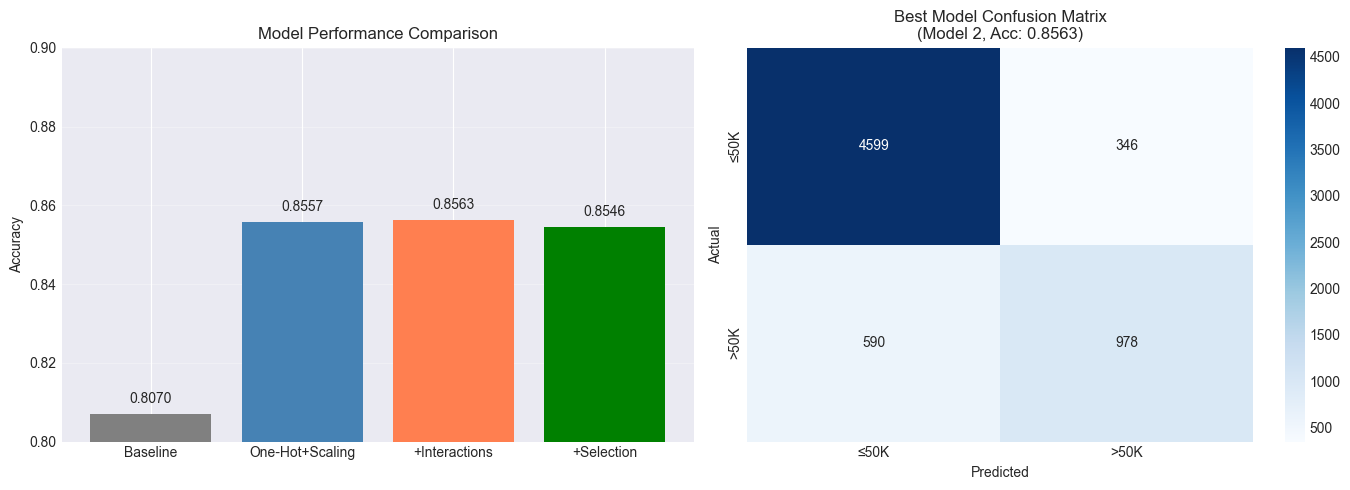

In [7]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['Baseline', 'One-Hot+Scaling', '+Interactions', '+Selection']
accuracies = [baseline['accuracy'], acc1, acc2, acc3]

axes[0].bar(models, accuracies, color=['gray', 'steelblue', 'coral', 'green'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylim([0.8, 0.9])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom')

# Confusion matrix for best model
best_model_idx = np.argmax(accuracies[1:]) + 1
best_pred = [y_pred1, y_pred2, y_pred3][best_model_idx - 1]
cm = confusion_matrix(y_test, best_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['≤50K', '>50K'],
            yticklabels=['≤50K', '>50K'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Best Model Confusion Matrix\n(Model {best_model_idx}, Acc: {accuracies[best_model_idx]:.4f})')

plt.tight_layout()
plt.show()


## Feature Importance Analysis


Top 20 Most Important Features:
  Feature 33: 1.8309
  Feature 96: 1.6480
  Feature 46: 1.4309
  Feature 56: 1.3239
  Feature 32: 1.2262
  Feature 3: 1.1333
  Feature 7: 1.1124
  Feature 62: 1.0835
  Feature 65: 1.0540
  Feature 54: 1.0006
  Feature 41: 0.9974
  Feature 67: 0.9672
  Feature 2: 0.9379
  Feature 9: 0.8712
  Feature 20: 0.8652
  Feature 50: 0.8419
  Feature 71: 0.8301
  Feature 61: 0.8249
  Feature 48: 0.8231
  Feature 42: 0.8047


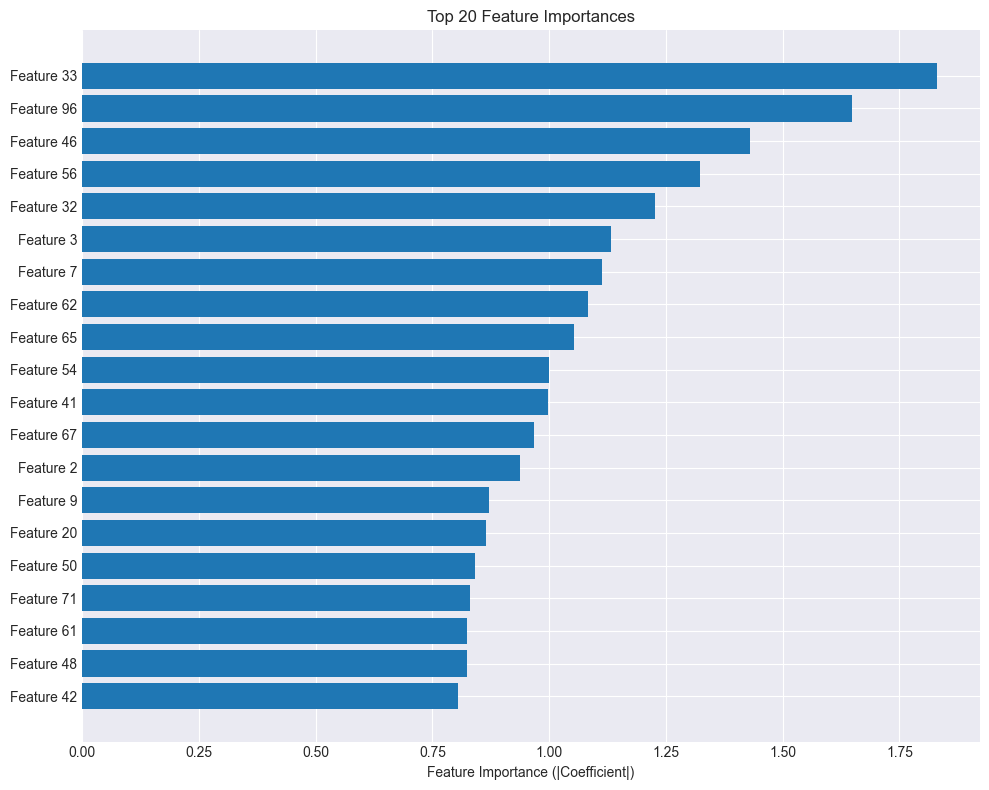


Results saved to '../feature_engineering_results.pkl'


In [8]:
# Get feature importance from best model
best_model = [model1, model2, model3][best_model_idx - 1]
feature_importance = np.abs(best_model.coef_[0])
top_20_idx = np.argsort(feature_importance)[-20:][::-1]

print("Top 20 Most Important Features:")
for idx in top_20_idx:
    print(f"  Feature {idx}: {feature_importance[idx]:.4f}")

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importance[top_20_idx])
plt.yticks(range(20), [f'Feature {i}' for i in top_20_idx])
plt.xlabel('Feature Importance (|Coefficient|)')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save results
results = {
    'baseline_accuracy': baseline['accuracy'],
    'model1_accuracy': acc1,
    'model2_accuracy': acc2,
    'model3_accuracy': acc3,
    'best_model': best_model,
    'preprocessor': preprocessor_enhanced if best_model_idx == 2 else preprocessor,
    'selector': selector if best_model_idx == 3 else None
}

with open('../feature_engineering_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\nResults saved to '../feature_engineering_results.pkl'")
